In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import pyBigWig


## Plot variance & peaks per experiment and correlation & peak overlap between experiments

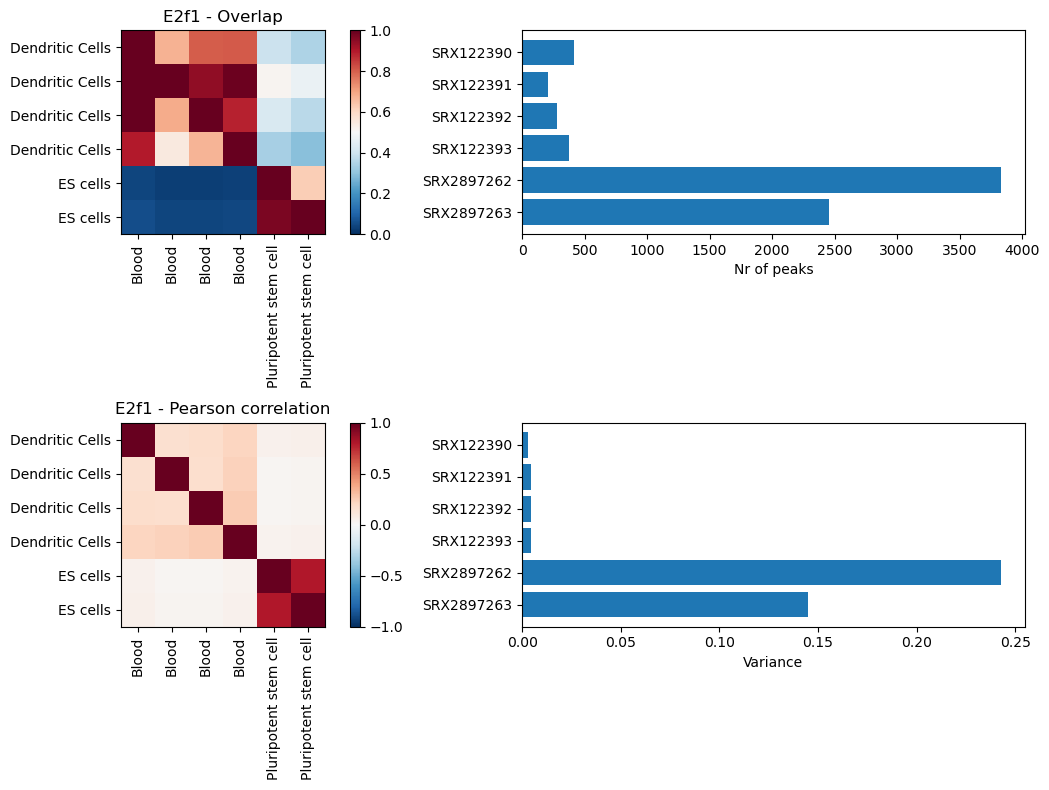

In [4]:
# parameters
genome = 'mm10'
win_size_kb = 5
bin_size = 20

CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']
TFs = ['E2f1']

# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"
promoterome = pd.read_csv(promoterome_infile,sep='\t')

for my_tf in TFs:
    # get TF tensor
    infile = f'../results/{genome}/Chip_tensors/Window_pm{win_size_kb}kb_bin_size_{bin_size}/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        X = hf['chip_prom_pos_exp'][:]
        my_ids = hf['chip_prom_pos_exp'].attrs['exp_id'].split(',')

    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)

    # replace nans with 0s
    X[np.isnan(X)] = 0
    N_prom, N_pos, N_exp = X.shape

    X_flat = X.reshape([N_prom*N_pos,N_exp])

    # compute pearson corr.
    rho = np.corrcoef(X_flat.T)
    v = np.nanvar(X_flat,axis=0)
    m = np.nanmean(X_flat,axis=0)
    # Z score
    #X = ((X - m) / np.sqrt(v)) + m

    # average per cell type
    X_ct = np.zeros([N_prom*N_pos,len(my_celltype)])
    for i in np.unique(celltype_idx):
        X_ct[:,i] = np.mean(X_flat[:,celltype_idx==i],axis=1)

    # get peak-peak overlap
    # get peaks
    peaks_table = pd.DataFrame(columns=['exp_id','chr','start','end','score'])
    peak_infiles = [f'../resources/tracks/{genome}/{id}.05.bb' for id in my_ids]
    for infile in peak_infiles:
        bb = pyBigWig.open(infile)
        id = infile.split('/')[-1].split('.')[0]
        for c in CHR:
            if c in bb.chroms():
                pks = pd.DataFrame(bb.entries(c,0,bb.chroms(c)),columns=['start','end','score'])
                pks['chr'] = c
                pks['exp_id'] = id
                peaks_table = pd.concat([peaks_table,pks],axis=0)
    peaks_table = peaks_table.reset_index(drop=True)

    N_peaks = peaks_table['exp_id'].value_counts() # count unique ids
    N_peaks = N_peaks.loc[my_ids]
    Peaks_Overlap = np.zeros([len(my_ids),len(my_ids)])
    for i,id_i in enumerate(my_ids):
        for j,id_j in enumerate(my_ids):
            for c in CHR:
                x = peaks_table.loc[(peaks_table.exp_id==id_i)&(peaks_table.chr==c),['start','end']].values
                y = peaks_table.loc[(peaks_table.exp_id==id_j)&(peaks_table.chr==c),['start','end']].values
                idx = (x[:,0][None,:] <= y[:,1][:,None]) & (x[:,1][None,:] >= y[:,0][:,None])

                Peaks_Overlap[i,j] += idx.sum()
            Peaks_Overlap[i,j] /= N_peaks[id_i]


    # plot
    fig, axes = plt.subplots(2,2,figsize=(12,8))
    ax = axes[0,0]
    h = ax.imshow(Peaks_Overlap,cmap='RdBu_r',vmin=0,vmax=1)
    plt.colorbar(h)
    ax.set_yticks(np.arange(N_exp),my_exp['celltype'],rotation=0)
    ax.set_xticks(np.arange(N_exp),my_exp['celltype_class'],rotation=90)
    ax.set_title(f"{my_tf} - Overlap")


    ax = axes[0,1]
    ax.barh(N_peaks.index,N_peaks.values)
    ax.set_xlabel('Nr of peaks')
    ax.invert_yaxis()


    ax = axes[1,0]
    h = ax.imshow(rho, cmap='RdBu_r',vmin=-1,vmax=1)
    # shopw colot bar
    plt.colorbar(h)
    ax.set_yticks(np.arange(N_exp),my_exp['celltype'],rotation=0)
    ax.set_xticks(np.arange(N_exp),my_exp['celltype_class'],rotation=90)
    ax.set_title(f'{my_tf} - Pearson correlation')
    fig.tight_layout()


    # plot variance
    ax = axes[1,1]
    V = pd.Series(v,index=my_ids)
    ax.barh(V.index,V.values)
    ax.set_xlabel('Variance')
    ax.invert_yaxis()


    if False:
        bins = np.linspace(X_ct.min(),X_ct.max(),200)

        n = len(my_celltype)

        fig, axes = plt.subplots(n,n,figsize=(n*4,n*4))
        for i in np.unique(celltype_idx):
            for j in np.unique(celltype_idx):
                ax = axes[i,j]
                if i==j:
                    h, tmp = np.histogram(X_ct[:,i],bins=bins)
                    ax.plot((bins[:-1]+bins[1:])/2,h)
                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    ax.set_title(f'{my_celltype[i]}')
                else:
                    ax.scatter(X_ct[:,i],X_ct[:,j],s=1,alpha=.5)
                    #ax.set_xscale('log')
                    #ax.set_yscale('log')
                    ax.set_title(f'{my_celltype[i]} vs {my_celltype[j]}')

## Compare variance in and out of peaks between experiments

In [5]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
win_size_kb = 5
bin_size = 20

CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"

v_in = {}
v_out = {}
h_in = {}
h_out = {}

for my_tf in TFs:
    print(my_tf)
    
    # get TF tensor
    infile = f'../results/{genome}/Chip_tensors/Window_pm{win_size_kb}kb_bin_size_{bin_size}/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        X = hf['chip_prom_pos_exp'][:]
        my_ids = hf['chip_prom_pos_exp'].attrs['exp_id'].split(',')

    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)

    # replace nans with 0s
    X[np.isnan(X)] = 0
    N_prom, N_pos, N_exp = X.shape
    X_flat = X.reshape([N_prom*N_pos,N_exp])
        
    # get peaks tensor
    infile = f'../results/mm10/Peak_tensors/Window_pm{win_size_kb}kb/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        Peaks = hf['peak_prom_pos_exp'][:]

    # get binned tensor
    Peaks_binned = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)
    Peaks_binned_flat = Peaks_binned.reshape([N_prom*N_pos,N_exp])

    N_bin = 100
    for i in range(N_exp):
        v_in[my_ids[i]] = np.nanvar(X_flat[Peaks_binned_flat[:,i],i])
        v_out[my_ids[i]] = np.nanvar(X_flat[~Peaks_binned_flat[:,i],i])
        h_in[my_ids[i]] = np.histogram(X_flat[Peaks_binned_flat[:,i],i],bins=N_bin)
        h_out[my_ids[i]] = np.histogram(X_flat[~Peaks_binned_flat[:,i],i],bins=N_bin)


E2f1
Mnt
Sox4
Pou2af1
Bach1
E2f3
Fosb
Otx2


: 

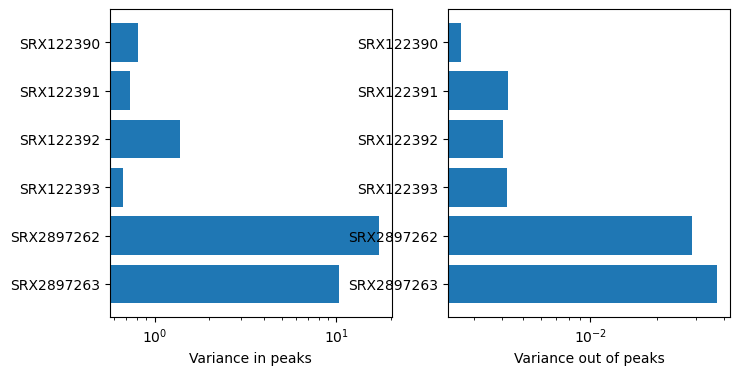

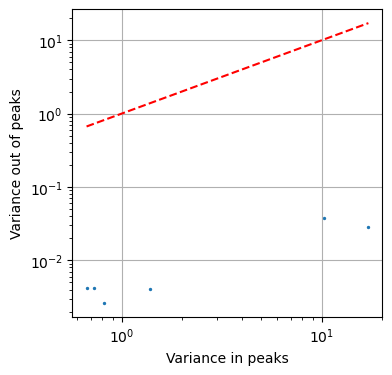

In [19]:
v_in = pd.Series(v_in)
v_out = pd.Series(v_out)

fig, axes = plt.subplots(1,2,figsize=(8,4))
ax = axes[0]
ax.barh(v_in.index,v_in.values)
ax.set_xlabel('Variance in peaks')
ax.invert_yaxis()
ax.set_xscale('log')

ax = axes[1]
ax.barh(v_out.index,v_out.values)
ax.set_xlabel('Variance out of peaks')
ax.invert_yaxis()
ax.set_xscale('log')

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot([v_in.min(),v_in.max()],[v_in.min(),v_in.max()],'r--')
ax.scatter(v_in.values,v_out.values,s=2)
ax.set_xlabel('Variance in peaks')
ax.set_ylabel('Variance out of peaks')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
if False:
    n = int(np.ceil(np.sqrt(len(h_in))))
    fig, axes = plt.subplots(n,n,figsize=(4*n,4*n))
    for i,id in enumerate(h_in):
        ax = axes.flatten()[i]
        ax.plot((h_in[id][1][:-1]+h_in[id][1][1:])/2,h_in[id][0],'.',label='in peaks')
        ax.plot((h_out[id][1][:-1]+h_out[id][1][1:])/2,h_out[id][0],'.',label='out of peaks')
        ax.set_yscale('log')
        ax.set_title(id)




## Quantile norm of TF ChIP signal

In [ ]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']

# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"

X = np.zeros([0,0,0])
for my_tf in TFs:
    print(my_tf)
    
    # get TF tensor
    infile = f'../results/{genome}/Chip_tensors/Window_pm{win_size_kb}kb_bin_size_{bin_size}/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        my_ids = [i.decode('utf-8') for i in hf['experiment_id'][:]]
        x = hf['chip_prom_pos_exp'][:]
    
    if X.size == 0:
        X = x
    else:
        X = np.concatenate([X,x],axis=2)

: 

In [ ]:
X = X.reshape([X.shape[0]*X.shape[1],X.shape[2]])

: 

In [ ]:

bins = np.logspace(-1,np.log10(X[~np.isnan(X)].max()),50)
#bins = np.linspace(0,X[~np.isnan(X)].max(),50)
dx = np.diff(bins)
H = np.zeros([len(bins)-1,X.shape[1]])
for i in range(X.shape[1]):
    idx = ~np.isnan(X[:,i])
    H[:,i], tmp = np.histogram(X[idx,i],bins=bins,density=False)

# normalize
#H = H / dx[:,None] 
H = H / H.sum(axis=0)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot((bins[:-1]+bins[1:])/2,H)
ax.set_xscale('log')
ax.set_yscale('log')



: 

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
h,x = np.histogram(np.log10( X[~np.isnan(X)] ),bins=100)

ax.plot((x[:-1]+x[1:])/2,h)
ax.set_yscale('log')

: 

# Truncated Gaussian fit

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import scipy
import h5py
# import pycircstat
from collections import namedtuple
from scipy import stats

# PCA & PPCA
from sklearn.decomposition import PCA
#from ppca import *

# from models_cellcycle import *
import jax
import jax.numpy as jnp
from jax import random, vmap, jit
import numpy as np
import numpyro
import numpyro.distributions as dist

# from params import 

from numpyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from numpyro.optim import Adam
# from numpyro.distributions import constraints
from numpyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoNormal
# import init_to_value
from numpyro.infer import init_to_value, init_to_feasible

from numpyro.infer import MCMC, NUTS, Predictive, HMCGibbs, DiscreteHMCGibbs, SA, reparam
from numpyro.distributions import TruncatedNormal,  NegativeBinomial2
from numpyro.infer import SVI, Trace_ELBO
from numpyro.optim import Adam


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
def truncated_normal_model(num_observations, x=None):
    loc = numpyro.param("loc", 0.0)
    scale = numpyro.param("scale", 1.0, constraint=dist.constraints.positive)
    low = numpyro.param("low", -1.0)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x", TruncatedNormal(loc, scale, low=low), obs=x)

def NegativeBinomial_model(num_observations, x=None):
    conc = numpyro.param("conc", 1.0, constraint=dist.constraints.positive)
    mean = numpyro.param("mean", 1.0, constraint=dist.constraints.positive)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x",  NegativeBinomial2(conc, mean), obs=x)

def Gamma_model(num_observations, x=None):
    alpha = numpyro.param("alpha", 1.0, constraint=dist.constraints.positive)
    beta = numpyro.param("beta", 1.0, constraint=dist.constraints.positive)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x",  dist.Gamma(alpha, beta), obs=x)

def Exponential_model(num_observations, x=None):
    rate = numpyro.param("rate", 1.0, constraint=dist.constraints.positive)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x",  dist.Exponential(rate), obs=x)

def guide(num_observations, x=None):
    pass

: 

In [ ]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
size_factor = 100000
bin_size = 20
win = 1
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win}kb_filtered.bed"

for my_tf in TFs:
    print(my_tf)

    # get TF tensor
    infile = f'../results/{genome}/TF_tensors/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        my_ids = [i.decode('utf-8') for i in hf['experiment_id'][:]]
        X = hf['chip_prom_pos_exp'][:]
    
    N_prom, N_pos, N_exp = X.shape
    X = X.reshape([N_prom*N_pos,N_exp])
    
    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)
        
    # get peaks tensor
    peak_infiles = [f'../resources/tracks/{genome}/{id}.05.bb' for id in my_ids]
    Peaks = make_peak_tensor(promoterome_infile,peak_infiles)

    # bin peaks
    Peaks_binned = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)
    Peaks_binned = Peaks_binned.reshape([N_prom*N_pos,N_exp])
    


: 

In [ ]:


fig, axes = plt.subplots(2,3,figsize=(8,8))
for i in range(N_exp):
    data = X[~Peaks_binned[:,i],i]
    data[np.isnan(data)] = 0
    data = np.log10( data[~np.isnan(data)] +1)
    #data = data[~np.isnan(data)]

    h,x = np.histogram(data,bins=100)

    ax = axes.flatten()[i]
    ax.plot((x[:-1]+x[1:])/2,np.log10(h),'.')
    ax.set_title(np.var(data))


: 

In [ ]:
data

: 

: 

: 

In [ ]:
# find the MLE of the truncated normal using numpyro SVI
optimizer = Adam(step_size=0.001)
#svi = SVI(truncated_normal_model, guide, optimizer, loss=Trace_ELBO())
#svi = SVI(Gamma_model, guide, optimizer, loss=Trace_ELBO())
svi = SVI(Exponential_model, guide, optimizer, loss=Trace_ELBO())

# Training loop
rng_key = random.PRNGKey(np.random.randint(0, 1000))
n_steps = 1000


fig, axes = plt.subplots(2,3,figsize=(8,8))
for i in range(x.shape[1]):
#for i in range(1):
    
    data = x[~Peaks_binned[:,i],i]
    #data = np.log10( data[~np.isnan(data)] )
    data = data[~np.isnan(data)]
    
    num_observations = len(data)
    res=svi.run(rng_key, n_steps, num_observations, data)

    # fitted distribution
    if False:
        loc = res.params['loc']
        scale = res.params['scale']
        low = res.params['low']
        x_ = np.linspace(low, np.max(data), 100)
        y_ = scipy.stats.truncnorm.pdf(x_, a=(low-loc)/scale, b=np.inf, loc=loc, scale=scale)
        #y_ = scipy.stats.gamma.pdf(x_, alpha, scale=1/beta)

    rate = res.params['rate']
    x_ = np.linspace(0, np.max(data), 100)
    y_ = scipy.stats.expon.pdf(x_,scale=1/rate)

    ax = axes.flatten()[i]
    ax.hist(data,bins=20,density=True,label='data')
    ax.plot(x_,y_,label='fitted')
    ax.set_yscale('log')
    ax.legend()



#fig, axes = plt.subplots(2,3,figsize=(8,8))
#for i in range(x.shape[1]):
#    ax = axes.flatten()[i]
#    ax.hist(np.log10(x[~Peaks_binned[:,i],i]),bins=50)
#    ax.set_yscale('log')

: 

In [ ]:
res.params

: 